In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

import warnings
warnings.filterwarnings('ignore')

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

#機器學習
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit

#統計
import scipy.stats as st

# 設定 data_path
dir_data = './data/'

In [6]:
#安裝geopandas有許多坑，很容易error，可以參考 https://zhuanlan.zhihu.com/p/137628480，文中第3個方法
#地理資料相關
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries

from shapely import geos, geometry
from shapely.geometry import shape,LineString,Point,Polygon

import fiona
from fiona.crs import from_epsg,from_string

#繪圖相關
import folium
from folium import IFrame

#顏色相關
import seaborn as sns
import branca

In [7]:
#安裝道路分析 相關套件
import osmnx as ox
import networkx as nx

In [8]:
# 機器學習 模型
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 定義Function

In [9]:
# GIS編碼轉換
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf
def trans02(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

# 中文顯示
def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]
heading3 = """<h3>{}</h3>""".format


# 查看資料內容
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
        
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))        
        
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    

# 顏色 style
def style_function(feature):
    colors = color.get(int(feature['id']), None)
    site_color=site_colors.get(feature['properties']['縣市'])
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color':site_color,
        'fillColor': '#fff' if colors is None else colorscale(colors)
    }

def results_KPI(model,X,Y):
    scores_MSE = cross_validate(model, X, Y,scoring='neg_mean_squared_error',\
                            cv=10,return_estimator=True)
    scores_MAE = cross_validate(model, X, Y,scoring='neg_mean_absolute_error',\
                            cv=10,return_estimator=True)
    scores_R2 = cross_validate(model, X, Y,scoring='r2',\
                            cv=10,return_estimator=True)
    results_KPI = {}
    results_KPI['MSE'] = scores_MSE['test_score'].mean()
    results_KPI['MAE'] = scores_MAE['test_score'].mean()
    results_KPI['R2'] = scores_R2['test_score'].mean()
    return results_KPI

def models_result(train_X,train_Y):
    lr = LinearRegression()
    kpi = results_KPI(lr, train_X, train_Y)
    print('lr :',kpi)

    dr= DecisionTreeRegressor()
    kpi = results_KPI(dr, train_X, train_Y)
    print('dr :',kpi)
    
    rf= RandomForestRegressor(random_state=1)
    kpi = results_KPI(rf, train_X, train_Y)
    print('rf :',kpi)
    
    gb= GradientBoostingRegressor(random_state=1)
    kpi = results_KPI(gb, train_X, train_Y)
    print('gb :',kpi)
    



# Define a function for model evaluation using cross validation
def evaluate_model_cross_validation(name, model, X_train, y_train, folds = 10):

    from sklearn.model_selection import cross_val_score
 
    # Cross Validation Regression MAE
    metric='neg_mean_absolute_error'
    scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    print('>%s - training - MAE: %.3f (+/-%.3f)' % (name, mean_score, std_score))
    
    
    # Cross Validation Regression MSE
    metric='neg_mean_squared_error'
    scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    print('>%s - training - MSE: %.3f (+/-%.3f)' % (name, mean_score, std_score))
    
    # Cross Validation Regression R^2
    metric='r2'
    scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    print('>%s - training - R^2: %.3f (+/-%.3f)' % (name, mean_score, std_score))
    
# Define a function for model evaluation using a test set
def evaluate_model_test_set(name, model, y_test, y_predicted):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    print('>%s - test - MAE: %.3f' % (name, mean_absolute_error(y_test, y_predicted)))
    print('>%s - test - MSE: %.3f' % (name, mean_squared_error(y_test, y_predicted)))
    print('>%s - test - R^2: %.3f' % (name, r2_score(y_test, y_predicted)))

# 匯入主要資料

In [10]:
f_path = os.path.join(dir_data, 'Real estate valuation data set.xlsx')
print('Path of read in data: %s' % (f_path))

df = pd.read_excel(f_path)

Path of read in data: ./data/Real estate valuation data set.xlsx


In [11]:
df.columns = ['No','Trans_Date','Age','D2MRT','n_convenience_stores','lat','lon','Y']
print(np.array(df.columns))
columns_type(df)
object_check(df)
print('\n')
print('Data na_check')
na_check(df)

['No' 'Trans_Date' 'Age' 'D2MRT' 'n_convenience_stores' 'lat' 'lon' 'Y']
類型 :  int64 

  個數 :  2 

   ['No', 'n_convenience_stores'] 

-----------------------------------------------

類型 :  float64 

  個數 :  6 

   ['Trans_Date', 'Age', 'D2MRT', 'lat', 'lon', 'Y'] 

-----------------------------------------------



,Column,Unique Count




Data na_check


,Missing Ratio


# 匯入相關資料

## 捷運資料

In [12]:
f_path = os.path.join(dir_data, 'GIS/捷運_1100406/MRT_1100406.shp')
print('Path of read in data: %s' % (f_path))

gdf_mrt = gpd.read_file(f_path,encoding='utf-8')
print(gdf_mrt['MRTCODE'].unique())

f_path = os.path.join(dir_data, 'GIS/捷運_1100406/捷運站經緯度.xlsx')
print('Path of read in data: %s' % (f_path))
MRT = pd.read_excel(f_path)
MRT_sub=MRT[MRT['station_name_tw'].isin(['景美','大坪林','七張','新店區公所','新店','小碧潭','南勢角','景安','永安市場','頂溪'])].reset_index(drop=True)

Path of read in data: ./data/GIS/捷運_1100406/MRT_1100406.shp
['中和新蘆線' '文湖線' '板南線' '淡水信義線' '機場捷運' '松山新店線' None '貓空纜車' '新北投線' '綠線' '紅線'
 '橘線' '環狀線' '三鶯線' '小碧潭線']
Path of read in data: ./data/GIS/捷運_1100406/捷運站經緯度.xlsx


## 道路資料

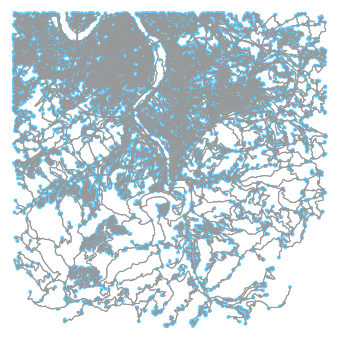

(<Figure size 474.732x432 with 1 Axes>, <AxesSubplot:>)

In [14]:
# https://geoffboeing.com/2016/11/osmnx-python-street-networks/
# drive, drive_service, walk, bike, all, all_private
site_lat = 24.956544
site_lon = 121.536432
G = ox.graph_from_point((site_lat, site_lon), dist=7000, network_type='all')
ox.plot_graph(G)

### 1. 距離捷運的步行距離

In [15]:
G = ox.project_graph(G) # 投影
gdf1,gdf2=ox.graph_to_gdfs(G)

meters_per_minute = 30 * 1000 / 60 # 每小時30公里
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [16]:
trip_times = [1, 2, 4] #分鐘
# 給定顏色
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)


for i in range(MRT_sub.shape[0]):
    if i == 0:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0_base = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1_base = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2_base = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
        
    else:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0 = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1 = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2 = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
    
        sub_convex0_base = gpd.overlay(sub_convex0_base,sub_convex0,  how='union')
        sub_convex1_base = gpd.overlay(sub_convex1_base,sub_convex1,  how='union')
        sub_convex2_base = gpd.overlay(sub_convex2_base,sub_convex2,  how='union')
        
        sub_convex0_base['df']=0
        sub_convex0_base = sub_convex0_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex1_base['df']=1
        sub_convex1_base = sub_convex1_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex2_base['df']=2
        sub_convex2_base = sub_convex2_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]


sub_convex0_base = gpd.GeoDataFrame(sub_convex0_base,crs = gdf1.crs)
sub_convex1_base = gpd.GeoDataFrame(sub_convex1_base,crs = gdf1.crs)
sub_convex2_base = gpd.GeoDataFrame(sub_convex2_base,crs = gdf1.crs)

1


### 2. 主要幹道

In [17]:
roads = ['北新路一段','北新路二段','北新路三段','寶橋路','中興路三段','中興路二段','中興路一段','中央路','永和路二段']
main_roads = gdf2[ (gdf2.name.apply(lambda x :x in roads)) |\
    ( (gdf2.name=='中正路') & (gdf2.ref=='北101') ) |\
    ( (gdf2.name=='中正路') & (gdf2.ref=='北95') ) |\
    ( (gdf2.name=='民權路') & (gdf2.ref=='北96') ) ]

main_roads_buffer = main_roads.copy()
main_roads_buffer = main_roads_buffer.to_crs(epsg=3826)
main_roads_buffer['geometry'] = main_roads_buffer.buffer(50)
main_roads_buffer = main_roads_buffer.dissolve(by='name').reset_index()

<AxesSubplot:>

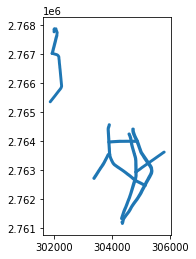

In [18]:
main_roads_buffer.plot()

## 生活圈、住宅區

In [19]:
bs=['七張裕隆生活圈','五峰生活圈','中央新村湯泉住宅區']
f_path = os.path.join(dir_data, 'GIS/商圈/'+bs[0]+'/POLYGON.shp')
print('Path of read in data: %s' % (f_path))
bs01 = gpd.read_file(f_path,encoding='utf-8')
bs01['business']=bs[0]

f_path = os.path.join(dir_data, 'GIS/商圈/'+bs[1]+'/POLYGON.shp')
print('Path of read in data: %s' % (f_path))
bs02 = gpd.read_file(f_path,encoding='utf-8')
bs02['business']=bs[1]

f_path = os.path.join(dir_data, 'GIS/商圈/'+bs[2]+'/POLYGON.shp')
print('Path of read in data: %s' % (f_path))
bs03 = gpd.read_file(f_path,encoding='utf-8')
bs03['business']=bs[2]
                                             
bs01 = pd.concat([bs01,bs02]).reset_index(drop=True)
bs01 = pd.concat([bs01,bs03]).reset_index(drop=True)

Path of read in data: ./data/GIS/商圈/七張裕隆生活圈/POLYGON.shp
Path of read in data: ./data/GIS/商圈/五峰生活圈/POLYGON.shp
Path of read in data: ./data/GIS/商圈/中央新村湯泉住宅區/POLYGON.shp


## 村里邊界

In [20]:
f_path = os.path.join(dir_data, 'GIS/村里邊界/VILLAGE_MOI_1090423.shp')
print('Path of read in data: %s' % (f_path))

gdf = gpd.read_file(f_path,encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf=trans(gdf)
gdf=gdf.dropna().reset_index(drop=True)
gdf.columns=['縣市','行政區','村里','geometry']
print(gdf.shape)

gdf_boundry=gdf.loc[ ( (gdf['縣市'].isin(['臺北市','新北市'])) & (gdf['行政區'].isin(['新店區','中和區','永和區','文山區']))), :]

gdf_boundry=gdf_boundry.dissolve(by='行政區').reset_index()
gdf_boundry

Path of read in data: ./data/GIS/村里邊界/VILLAGE_MOI_1090423.shp
(7760, 4)


,行政區,geometry,縣市,村里
0,中和區,"POLYGON ((121.46811 24.99369, 121.46806 24.993...",新北市,華新里
1,文山區,"POLYGON ((121.59606 25.00431, 121.59613 25.004...",臺北市,樟新里
2,新店區,"POLYGON ((121.56652 24.90373, 121.56650 24.903...",新北市,龜山里
3,永和區,"POLYGON ((121.50822 25.00247, 121.50830 25.002...",新北市,智光里


## 2012年 所得資料

In [21]:
f_path = os.path.join(dir_data, 'GIS/所得/2012年村里所得資料.csv')
print('Path of read in data: %s' % (f_path))
Income = pd.read_csv(f_path)

Income = Income[-Income['村里'].isin(['合計','其他'])].reset_index(drop=True)
Income.rename(columns={'鄉鎮市區':'行政區'},inplace=True)

Income['村里']=Income['村里'].apply(lambda x:x.replace('五峰里','五峯里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('灰\U000fc355里','灰磘里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('瓦\U000fc355里','瓦磘里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('新\U000fffb4里','新廍里'))

gdf_sub = gdf.loc[ ( (gdf['縣市'].isin(['臺北市','新北市'])) & (gdf['行政區'].isin(['新店區','中和區','永和區','文山區']))), :].reset_index(drop=True)
Income['site'] = Income['縣市'] + Income['行政區']+ Income['村里']
gdf_sub['site'] = gdf_sub['縣市'] + gdf_sub['行政區']+ gdf_sub['村里']
gdf_final = pd.merge(gdf_sub,Income)

Path of read in data: ./data/GIS/所得/2012年村里所得資料.csv


# 繪圖

## 主要資料

In [22]:
df_train = df.copy()

df_train['Y_2']=df_train['Y']
df_train['Y_2'][df_train['Y_2']>80]=80
df_train['D2MRT'][df_train['D2MRT']>2000]=2000

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)

d1 = gpd.sjoin(df_train, sub_convex2_base.to_crs(df_train.crs), op = 'within')['No'].values

In [23]:
#想畫顏色的變數
variable='Y_2'

#設定色階
df_train['id']=df_train.index
color=df_train.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8

colorscale_Y = branca.colormap.linear.YlOrRd_09.scale(low, high)
df_train['color'] = color.apply(lambda x : colorscale_Y(x))
colorscale_Y

## 所得資料

In [24]:
site=['基隆市','新北市', '台北市','桃園市','新竹縣','新竹市','苗栗縣','台中市','彰化縣','南投縣',
      '雲林縣','嘉義縣','嘉義市','台南市',
      '高雄市','屏東縣','宜蘭縣','花蓮縣','台東縣',
      '澎湖縣','金門縣','連江縣']

site_colors={'基隆市':'#6e5e4c','新北市':'#6e5e4c', '台北市':'#6e5e4c',
            '桃園市':'#968278','新竹縣':'#968278','新竹市':'#968278','苗栗縣':'#968278',
            '台中市':'#6e5e4c','彰化縣':'#6e5e4c','南投縣':'#6e5e4c','澎湖縣':'#6e5e4c','金門縣':'#6e5e4c','連江縣':'#6e5e4c',
            '雲林縣':'#968278','嘉義縣':'#968278','嘉義市':'#968278','台南市':'#968278',
            '高雄市':'#6e5e4c','屏東縣':'#6e5e4c',
            '宜蘭縣':'#968278','花蓮縣':'#968278','台東縣':'#968278'}

#想畫顏色的變數
variable='平均數'

#設定色階
gdf_final['id']=gdf_final.index
color=gdf_final.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
colorscale

In [25]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]

In [26]:
# 設定圖例
colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
colormap.caption ='Income'


# 設定圖例
colormap_Y=colorscale_Y
colormap_Y.caption ='Y'

In [27]:
# 設定地圖一開始顯示的中心與大小
mm=folium.Map(location=台北車站,zoom_start=13,\
              #tiles="Cartodb Positron"\
             )

#行政區邊界
dis=1
if dis==1:
    folium.GeoJson(
        gdf_boundry,
        style_function = lambda x: {
            'color': '#642100',
            'weight': 4,
            'fillOpacity': 0.2
        },
        name='行政區邊界').add_to(mm)


#重要生活區
bs=1
if bs==1:
    folium.GeoJson(
        bs01,
        style_function = lambda x: {
            'color': '#9F5000',
            'weight': 4,
            'fillOpacity': 0.2
        },
        name='重要生活區').add_to(mm)


# 所得
folium.GeoJson(
    gdf_final[['geometry','縣市','行政區','村里','平均數','中位數','標準差']],
    name='所得', 
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 
                                    'color':site_colors.get(x['properties']['縣市']),
                                    'fillOpacity':0.75},
    smooth_factor=2.0,
    tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','平均數','中位數'],
                                                aliases=['縣市','行政區','村里','平均數','中位數'], 
                                                labels=True, 
                                                sticky=True,
                                                toLocaleString=True
                                                )
).add_to(mm)    
    
    


#捷運路線
folium.GeoJson(
        gdf_mrt.loc[gdf_mrt['MRTCODE'].isin(['松山新店線','小碧潭線','中和新蘆線']),:],
        
        name='捷運路線').add_to(mm)

#捷運站
if 1==1:
    #MRT_cluster = MarkerCluster(name='MRT').add_to(mm)
    fg1=folium.FeatureGroup(name='MRT', show=True)
    for i in range(MRT.shape[0]):
        if MRT.line_code[i] in ['G','O']:
            iframe = IFrame(html=heading3(utf2asc(MRT.station_name_tw[i])),width=250,height=50)
            popup = folium.Popup(iframe)
            folium.Marker(location=[MRT.lat[i], MRT.lon[i]],
                           popup=popup,
                           icon=folium.Icon(icon='train',
                                            color='black',
                                            icon_color=MRT.color[i],
                                            prefix='fa')).add_to(fg1)
    mm.add_child(fg1)

#距離遠近
if 1==1:
    fg2=folium.FeatureGroup(name='遠', show=True)
    fg3=folium.FeatureGroup(name='中', show=True)
    fg4=folium.FeatureGroup(name='近', show=True)
    folium.Choropleth(geo_data=sub_convex0_base,fill_color=iso_colors[0],fill_opacity=0.15).add_to(fg2)
    mm.add_child(fg2)
    folium.Choropleth(geo_data=sub_convex1_base,fill_color=iso_colors[1],fill_opacity=0.175).add_to(fg3)
    mm.add_child(fg3)
    folium.Choropleth(geo_data=sub_convex2_base,fill_color=iso_colors[2],fill_opacity=0.2).add_to(fg4)
    mm.add_child(fg4)

#道路交叉口
if 1==0:
    fg5=folium.FeatureGroup(name='道路交叉口', show=True)
    for idx,data in gdf1.iterrows():
        if idx==center_node:
            folium.Circle([data.geometry.y,data.geometry.x],radius=100,color='yellow',fill=True).add_to(fg5)
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
        else:
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
    mm.add_child(fg5)    

if 1==1:
    fg6=folium.FeatureGroup(name='主要幹道', show=True)
    folium.Choropleth(geo_data=main_roads_buffer,fill_color='yellow',fill_opacity=0.5).add_to(fg6)
    mm.add_child(fg6)

#房屋位置
if 1==1:
    num=df_train.shape[0]
    lat=np.array(df_train["lat"][0:num])
    lon=np.array(df_train["lon"][0:num])
    data1=[[lat[i],lon[i],1] for i in range(num)]
    fg1=folium.FeatureGroup(name='房屋(點)', show=True)
    for i in range(num):
        if ((1==1) | (df_train['No'][i] in d1)):
            folium.Circle(location=[data1[i][0],data1[i][1]],
            color=df_train['color'][i], # Circle 顏色
            radius=25, # Circle 寬度
            popup=str(df_train['Y'][i])+' : '+str(df_train['No'][i]),
            fill=True, # 填滿中間區域
            fill_opacity=0.7 # 設定透明度
            ).add_to(fg1)
    mm.add_child(fg1)    
    
    
#colormap.add_to(mm)
colormap_Y.add_to(mm)

folium.LayerControl().add_to(mm)

In [28]:
mm

In [29]:
#mm.save('新店房價分析.html')

# 模型分析

## EDA

In [30]:
df_train = df.copy()
print(df_train.shape)

#ETL
df_train['Year'] = df_train['Trans_Date'].astype('int')
df_train['Month'] = (((df_train['Trans_Date'] - df_train['Trans_Date'].astype('int')) * 12) + 1).astype('int')
df_train['ln_D2MRT']=np.log1p(df_train['D2MRT'])

(414, 8)


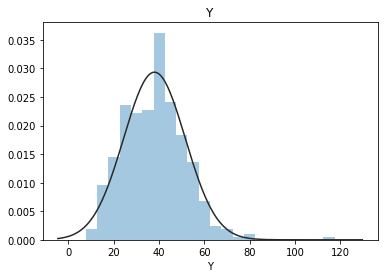

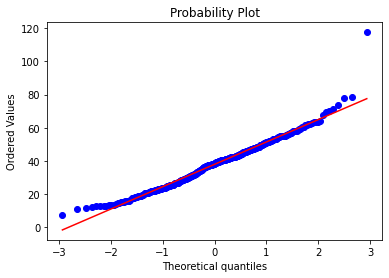

In [31]:
plt.figure(1)
plt.title('Y')
sns.distplot(df_train['Y'], kde=False, fit=st.norm)

plt.figure(2)
res = st.probplot(df_train['Y'],plot=plt)

# plt.figure(3)
# plt.title('ln Y')
# sns.distplot(np.log(df_train['Y']), kde=False, fit=st.norm)

# plt.figure(4)
# res =  st.probplot(np.log(df_train['Y']),plot=plt)

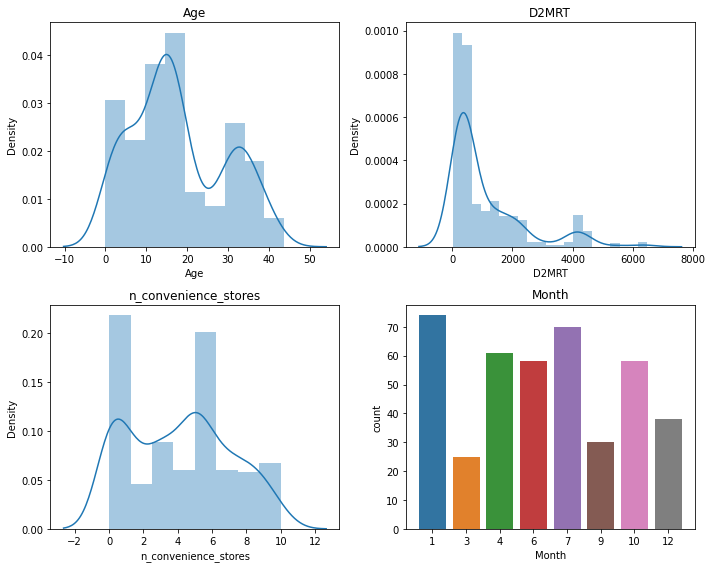

In [32]:
# 單變數

# 設定繪圖區域的長與寬
fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(2, 2, 1)
sns.distplot(df_train.loc[:, 'Age'])
ax_1.set_title("Age")

ax_2 = fig.add_subplot(2, 2, 2)
sns.distplot(df_train.loc[:, 'D2MRT'])
ax_2.set_title("D2MRT")

ax_3 = fig.add_subplot(2, 2, 3)
sns.distplot(df_train.loc[:, 'n_convenience_stores'])
ax_3.set_title("n_convenience_stores")

ax_4 = fig.add_subplot(2, 2, 4)
sns.countplot(x='Month',data=df_train)
ax_4.set_title("Month")

fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

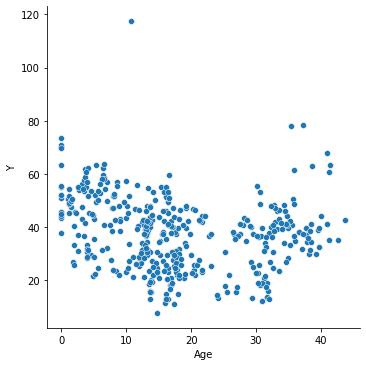

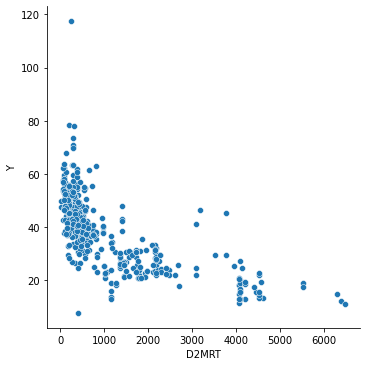

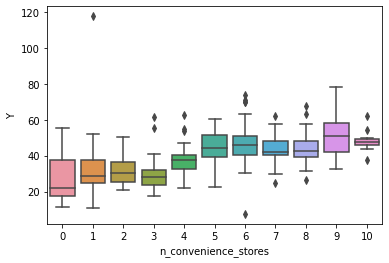

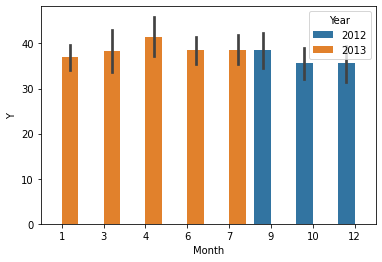

In [33]:
sns.relplot(x = 'Age', y = 'Y', kind="scatter",data=df_train)
plt.show()

sns.relplot(x = 'D2MRT', y = 'Y', kind="scatter",data=df_train)
plt.show()

# sns.relplot(x = 'ln_D2MRT', y = 'Y', kind="scatter",data=df_train)
# plt.show()

sns.boxplot(x = 'n_convenience_stores', y = 'Y',data=df_train)
plt.show()

sns.barplot(x='Month',y='Y',hue='Year',data=df_train)
plt.show()

In [34]:
correlations = df_train.loc[:,['Y','Age','D2MRT','n_convenience_stores','lon','lat']].corr()

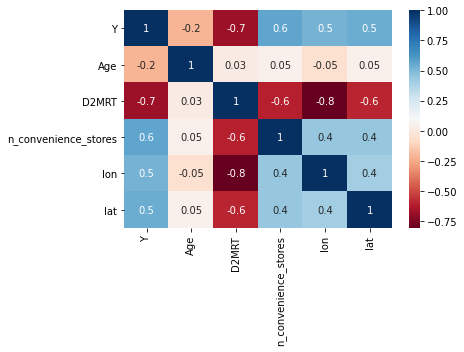

In [35]:
sns.heatmap(correlations,cmap = 'RdBu',annot=True,fmt ='0.1g')
plt.show()

## Features selection

### Bases Model  X  原始變數

In [36]:
df.columns

Index(['No', 'Trans_Date', 'Age', 'D2MRT', 'n_convenience_stores', 'lat',
       'lon', 'Y'],
      dtype='object')

In [147]:
df_train = df.copy()

# ETL
df_train = df_train[df_train.Y<100].reset_index(drop=True)

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)
geom = [Point(data.lon,data.lat) for idx,data in MRT_sub.iterrows()]
crs = {'init': 'epsg:4326'}
MRT_sub = gpd.GeoDataFrame(MRT_sub, crs=crs, geometry=geom)
MRT_sub = trans02(MRT_sub)
df_train['D2MRT_new']=np.nan
for i in range(df_train.shape[0]):
    df_train['D2MRT_new'][i] = min(MRT_sub.distance(df_train.geometry[i]))

# split
df_train['D2MRT_new_cut'] = pd.qcut(df_train['D2MRT_new'],5,labels=range(5))
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=12)
for train_index, test_index in split.split(df_train,df_train.loc[:,['D2MRT_new_cut']]):
    train_set = df_train.loc[train_index]
    test_set = df_train.loc[test_index]

#,'Trans_Date','lon','lat', 'Age','D2MRT','n_convenience_stores','Trans_Date','lon','lat'
cols = ['Age','D2MRT_new','n_convenience_stores','lon','lat']
X_train, y_train = train_set.loc[:,cols], train_set.loc[:,['Y']]
X_test, y_test = test_set.loc[:,cols], test_set.loc[:,['Y']]

mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

In [148]:
# Model
lr = LinearRegression()
evaluate_model_cross_validation(name='LinearRegression', model=lr, X_train=X_train, y_train=y_train, folds = 10)

print('\n')
dtree = DecisionTreeRegressor(min_samples_split=10)
evaluate_model_cross_validation(name='DecisionTreeRegressor', model=dtree, X_train=X_train, y_train=y_train, folds = 10)

#,min_samples_split=10,
print('\n')
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
evaluate_model_cross_validation(name='RandomForestRegressor', model=rf, X_train=X_train, y_train=y_train, folds = 10)

print('\n')
gb = GradientBoostingRegressor(random_state=12,min_samples_split=10)
evaluate_model_cross_validation(name='GradientBoostingRegressor', model=gb, X_train=X_train, y_train=y_train, folds = 10)


>LinearRegression - training - MAE: -6.036 (+/-0.726)
>LinearRegression - training - MSE: -63.760 (+/-21.676)
>LinearRegression - training - R^2: 0.595 (+/-0.129)


>DecisionTreeRegressor - training - MAE: -5.681 (+/-0.883)
>DecisionTreeRegressor - training - MSE: -63.603 (+/-21.990)
>DecisionTreeRegressor - training - R^2: 0.581 (+/-0.161)


>RandomForestRegressor - training - MAE: -4.835 (+/-0.767)
>RandomForestRegressor - training - MSE: -47.917 (+/-20.299)
>RandomForestRegressor - training - R^2: 0.706 (+/-0.081)


>GradientBoostingRegressor - training - MAE: -4.824 (+/-0.815)
>GradientBoostingRegressor - training - MSE: -49.637 (+/-22.152)
>GradientBoostingRegressor - training - R^2: 0.694 (+/-0.100)


In [149]:
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

evaluate_model_test_set(name='RandomForestRegressor', model=rf, y_test=y_test, y_predicted=y_pred)

>RandomForestRegressor - test - MAE: 4.667
>RandomForestRegressor - test - MSE: 45.042
>RandomForestRegressor - test - R^2: 0.752


In [82]:
#pd.DataFrame({'y_test':y_test.values.reshape(-1),'y_pred':y_pred.reshape(-1)})

### 更多變數

In [165]:
df_train = df.copy()

# ETL
df_train = df_train[df_train.Y<100].reset_index(drop=True)

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)
geom = [Point(data.lon,data.lat) for idx,data in MRT_sub.iterrows()]
crs = {'init': 'epsg:4326'}
MRT_sub = gpd.GeoDataFrame(MRT_sub, crs=crs, geometry=geom)
MRT_sub = trans02(MRT_sub)
df_train['D2MRT_new']=np.nan
for i in range(df_train.shape[0]):
    df_train['D2MRT_new'][i] = min(MRT_sub.distance(df_train.geometry[i]))

    
d1 = gpd.sjoin(df_train, sub_convex2_base.to_crs(df_train.crs), op = 'within')['No'].values
d2 = gpd.sjoin(df_train, sub_convex1_base.to_crs(df_train.crs), op = 'within')['No'].values
d3 = gpd.sjoin(df_train, sub_convex0_base.to_crs(df_train.crs), op = 'within')['No'].values
df_train['d1'] = 0
df_train.loc[ (df_train['No'].isin(d1)) ,['d1']]=1
df_train['d2'] = 0
df_train.loc[ (-df_train['No'].isin(d1) & (df_train['No'].isin(d2))) ,['d2']]=1
df_train['d3'] = 0
df_train.loc[ (-df_train['No'].isin(d1) & (-df_train['No'].isin(d2)) & (df_train['No'].isin(d3))) ,['d3']]=1

df_train=gpd.sjoin(df_train, gdf_final.loc[:,['site','平均數','中位數','geometry']].to_crs(df_train.crs), op = 'within')
df_train.rename(columns={'平均數':'income_mean','中位數':'income_median'},inplace=True)
df_train.drop(columns=['index_right'],inplace=True)
df_train = df_train.sort_index().reset_index(drop=True)

main_roads_2=main_roads.copy().reset_index()
main_roads_2 = main_roads_2.to_crs(epsg=3826)
main_roads_2 = main_roads_2.dissolve(by='key').reset_index()
dis_main_roads = df_train.geometry.geometry.distance(main_roads_2.geometry[0])
df_train['dis_main_roads']=dis_main_roads

b1 = gpd.sjoin(df_train, bs01.iloc[[0],:].to_crs(df_train.crs), op = 'within')['No'].values
b2 = gpd.sjoin(df_train, bs01.iloc[[1],:].to_crs(df_train.crs), op = 'within')['No'].values
b3 = gpd.sjoin(df_train, bs01.iloc[[2],:].to_crs(df_train.crs), op = 'within')['No'].values
df_train['b1'] = 0
df_train.loc[(df_train['No'].isin(b1)),['b1']]=1
df_train['b2'] = 0
df_train.loc[(df_train['No'].isin(b2)),['b2']]=1
df_train['b3'] = 0
df_train.loc[(df_train['No'].isin(b3)),['b3']]=1


# split
df_train['D2MRT_new_cut'] = pd.qcut(df_train['D2MRT_new'],5,labels=range(5))
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=12)
for train_index, test_index in split.split(df_train,df_train.loc[:,['D2MRT_new_cut']]):
    train_set = df_train.loc[train_index]
    test_set = df_train.loc[test_index]

# 'D2MRT', 'D2MRT_new','d1','d2','d3','income_median', 'income_mean','b1','b2','b3','dis_main_roads'
cols = ['Age','n_convenience_stores','lon','lat','dis_main_roads','d1','d2','d3','b1','b2','b3']    
X_train, y_train = train_set.loc[:,cols], train_set.loc[:,['Y']]
X_test, y_test = test_set.loc[:,cols], test_set.loc[:,['Y']]

mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

In [166]:
# Model
lr = LinearRegression()
evaluate_model_cross_validation(name='LinearRegression', model=lr, X_train=X_train, y_train=y_train, folds = 10)

print('\n')
dtree = DecisionTreeRegressor(min_samples_split=10)
evaluate_model_cross_validation(name='DecisionTreeRegressor', model=dtree, X_train=X_train, y_train=y_train, folds = 10)

#,min_samples_split=10,
print('\n')
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
evaluate_model_cross_validation(name='RandomForestRegressor', model=rf, X_train=X_train, y_train=y_train, folds = 10)

print('\n')
gb = GradientBoostingRegressor(random_state=12,min_samples_split=10)
evaluate_model_cross_validation(name='GradientBoostingRegressor', model=gb, X_train=X_train, y_train=y_train, folds = 10)


>LinearRegression - training - MAE: -4.887 (+/-0.759)
>LinearRegression - training - MSE: -49.989 (+/-20.184)
>LinearRegression - training - R^2: 0.688 (+/-0.102)


>DecisionTreeRegressor - training - MAE: -5.389 (+/-0.770)
>DecisionTreeRegressor - training - MSE: -53.619 (+/-19.366)
>DecisionTreeRegressor - training - R^2: 0.660 (+/-0.115)


>RandomForestRegressor - training - MAE: -4.735 (+/-0.748)
>RandomForestRegressor - training - MSE: -44.230 (+/-17.504)
>RandomForestRegressor - training - R^2: 0.724 (+/-0.080)


>GradientBoostingRegressor - training - MAE: -4.803 (+/-0.761)
>GradientBoostingRegressor - training - MSE: -44.405 (+/-17.425)
>GradientBoostingRegressor - training - R^2: 0.725 (+/-0.071)


In [167]:
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

evaluate_model_test_set(name='RandomForestRegressor', model=rf, y_test=y_test, y_predicted=y_pred)

>RandomForestRegressor - test - MAE: 4.402
>RandomForestRegressor - test - MSE: 43.191
>RandomForestRegressor - test - R^2: 0.762


In [168]:
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
rf.fit(X_train,y_train)
ft_ipt = pd.DataFrame({'cols':cols,'important':rf.feature_importances_}).sort_values(by='important',ascending=False).reset_index(drop=True)

In [169]:
ft_ipt

,cols,important
0,dis_main_roads,0.687827
1,Age,0.133933
2,d1,0.050522
3,lat,0.048946
4,lon,0.036495
5,b1,0.019756
6,n_convenience_stores,0.016715
7,d2,0.002466
8,d3,0.001618
9,b2,0.001280


In [344]:
df_train = df.copy()

# ETL
df_train = df_train[df_train.Y<100].reset_index(drop=True)

geom = [Point(data.lon,data.lat) for idx,data in df_train.iterrows()]
crs = {'init': 'epsg:4326'}
df_train = gpd.GeoDataFrame(df_train, crs=crs, geometry=geom)
df_train = trans02(df_train)
geom = [Point(data.lon,data.lat) for idx,data in MRT_sub.iterrows()]
crs = {'init': 'epsg:4326'}
MRT_sub = gpd.GeoDataFrame(MRT_sub, crs=crs, geometry=geom)
MRT_sub = trans02(MRT_sub)
df_train['D2MRT_new']=np.nan
for i in range(df_train.shape[0]):
    df_train['D2MRT_new'][i] = min(MRT_sub.distance(df_train.geometry[i]))

    
d1 = gpd.sjoin(df_train, sub_convex2_base.to_crs(df_train.crs), op = 'within')['No'].values
d2 = gpd.sjoin(df_train, sub_convex1_base.to_crs(df_train.crs), op = 'within')['No'].values
d3 = gpd.sjoin(df_train, sub_convex0_base.to_crs(df_train.crs), op = 'within')['No'].values
df_train['d1'] = 0
df_train.loc[ (df_train['No'].isin(d1)) ,['d1']]=1
df_train['d2'] = 0
df_train.loc[ (-df_train['No'].isin(d1) & (df_train['No'].isin(d2))) ,['d2']]=1
df_train['d3'] = 0
df_train.loc[ (-df_train['No'].isin(d1) & (-df_train['No'].isin(d2)) & (df_train['No'].isin(d3))) ,['d3']]=1

df_train=gpd.sjoin(df_train, gdf_final.loc[:,['site','平均數','中位數','geometry']].to_crs(df_train.crs), op = 'within')
df_train.rename(columns={'平均數':'income_mean','中位數':'income_median'},inplace=True)
df_train.drop(columns=['index_right'],inplace=True)
df_train = df_train.sort_index().reset_index(drop=True)

main_roads_2=main_roads.copy().reset_index()
main_roads_2 = main_roads_2.to_crs(epsg=3826)
main_roads_2 = main_roads_2.dissolve(by='key').reset_index()
dis_main_roads = df_train.geometry.geometry.distance(main_roads_2.geometry[0])
df_train['dis_main_roads']=dis_main_roads

b1 = gpd.sjoin(df_train, bs01.iloc[[0],:].to_crs(df_train.crs), op = 'within')['No'].values
b2 = gpd.sjoin(df_train, bs01.iloc[[1],:].to_crs(df_train.crs), op = 'within')['No'].values
b3 = gpd.sjoin(df_train, bs01.iloc[[2],:].to_crs(df_train.crs), op = 'within')['No'].values
df_train['b1'] = 0
df_train.loc[(df_train['No'].isin(b1)),['b1']]=1
df_train['b2'] = 0
df_train.loc[(df_train['No'].isin(b2)),['b2']]=1
df_train['b3'] = 0
df_train.loc[(df_train['No'].isin(b3)),['b3']]=1

# 'D2MRT', 'D2MRT_new','d1','d2','d3','income_mean','b1','b2','b3','dis_main_roads'
cols = ['Age','D2MRT_new' ,'n_convenience_stores','Trans_Date','lon','lat','d1','d2','d3',\
        'income_median','b1','b2','b3','dis_main_roads']
train_X = df_train.loc[:,ft_ipt.cols[:6].values]
train_Y = df_train.loc[:,['Y']]

# split
# X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.2, random_state = 0)
train_X_1 = train_X[train_Y.Y>40]
train_Y_1 = train_Y[train_Y.Y>40]
train_X_2 = train_X[-(train_Y.Y>40)]
train_Y_2 = train_Y[-(train_Y.Y>40)]

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_X_1, train_Y_1, test_size = 0.2, random_state = 12)
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_X_2, train_Y_2, test_size = 0.2, random_state = 12)

X_train = pd.concat([X_train1,X_train2]).sort_index()
X_test = pd.concat([X_test1,X_test2]).sort_index()
y_train = pd.concat([y_train1,y_train2]).sort_index()
y_test = pd.concat([y_test1,y_test2]).sort_index()

mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(train_X)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

In [345]:
# Model
lr = LinearRegression()
evaluate_model_cross_validation(name='LinearRegression', model=lr, X_train=X_train, y_train=y_train, folds = 10)

print('\n')
dtree = DecisionTreeRegressor(min_samples_split=10)
evaluate_model_cross_validation(name='DecisionTreeRegressor', model=dtree, X_train=X_train, y_train=y_train, folds = 10)

#,min_samples_split=10,
print('\n')
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
evaluate_model_cross_validation(name='RandomForestRegressor', model=rf, X_train=X_train, y_train=y_train, folds = 10)

print('\n')
gb = GradientBoostingRegressor(random_state=12,min_samples_split=10)
evaluate_model_cross_validation(name='GradientBoostingRegressor', model=gb, X_train=X_train, y_train=y_train, folds = 10)


>LinearRegression - training - MAE: -5.719 (+/-0.619)
>LinearRegression - training - MSE: -61.233 (+/-19.463)
>LinearRegression - training - R^2: 0.608 (+/-0.079)


>DecisionTreeRegressor - training - MAE: -5.429 (+/-0.552)
>DecisionTreeRegressor - training - MSE: -58.125 (+/-11.893)
>DecisionTreeRegressor - training - R^2: 0.615 (+/-0.070)


>RandomForestRegressor - training - MAE: -4.568 (+/-0.695)
>RandomForestRegressor - training - MSE: -42.180 (+/-14.408)
>RandomForestRegressor - training - R^2: 0.727 (+/-0.071)


>GradientBoostingRegressor - training - MAE: -4.644 (+/-0.768)
>GradientBoostingRegressor - training - MSE: -43.261 (+/-15.224)
>GradientBoostingRegressor - training - R^2: 0.719 (+/-0.079)


In [346]:
rf = RandomForestRegressor(random_state=12,min_samples_split=10)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

evaluate_model_test_set(name='RandomForestRegressor', model=rf, y_test=y_test, y_predicted=y_pred)

>RandomForestRegressor - test - MAE: 5.153
>RandomForestRegressor - test - MSE: 62.365
>RandomForestRegressor - test - R^2: 0.701
